In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Functions as AC
from IPython.display import display, Math

## Description of System1 and System2 csv files

### Three parameters: 

$\quad$ -time_d: Time (days)

$\quad$ -rv_ms: Radial velocity (m/s)

$\quad$ -sig_rv_ms: Uncertainty on radial velocity measurements (m/s)

In [28]:
df1 = AC.data_loader('system1.csv')
df2 = AC.data_loader('system2.csv')

In [29]:
time1 = df1['time_d']
rv1 = df1['rv_ms']
sig1 = df1['sig_rv_ms']

time2 = df2['time_d']
rv2 = df2['rv_ms']
sig2 = df2['sig_rv_ms']

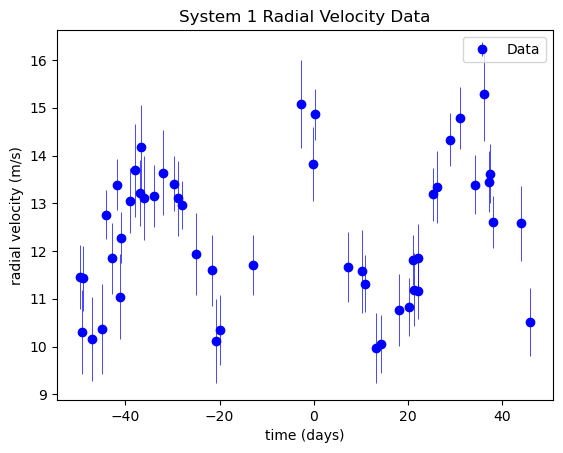

In [30]:
fig = plt.figure()
plt.errorbar(time1, rv1, yerr=sig1, elinewidth=.5, color='blue', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 1 Radial Velocity Data')
plt.legend()
plt.show()

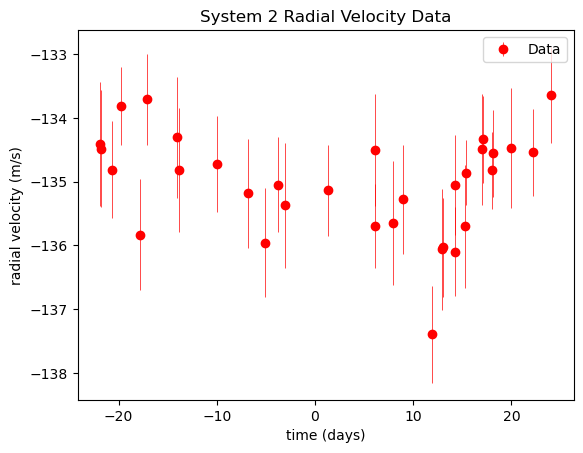

In [31]:
fig = plt.figure()
plt.errorbar(time2, rv2, yerr=sig2, elinewidth=.5, color='red', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 2 Radial Velocity Data')
plt.legend()
plt.show()

# The Forward Model

### Deriving the loglikelihood

Given a planet of mass m orbiting a star of mass M, with semi-major axis a, and eccentricity 0, the equation for the measured radial velocity of the system is:

$V(t) = V_0+K\cos(nt+\lambda_0)\;\;\;\;(1)\;\;$ where $\;\;K=\frac{m}{m+M}\frac{2\pi a\sin i}{P}\;\;$ is the radial velocity semi amplitude

The parameters of concern in this situation are $\theta=(V_0, K, \lambda_0)$

We can find an expression for the loglikelihood function:

Since we know that these measurements are affected by $\textbf{Uncorrelated Gaussian White Noise}$ we can compute the probability of the observation $v_k$ give $\theta$ as:

$p(v_k|\theta)=\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k;\theta))^2}{2\sigma_k^2}]\;\;\;\;(2)\;\;$

Since the GWN is uncorrelated this means that for each $v_k\;(1,...,k)$ given $\theta$ are independent so to get the total likelihood we simply multiply all probabilities together giving:

$\mathcal{L}=\prod_{k=1}^{N}[\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k))^2}{2\sigma_k^2}]]\;\;\;\;(3)\;\;$

$\because$ products are annoying to work with we can use properties of logs to get the loglikelihood as a summation as opposed to a product. Taking the natural log of both sides:

$ln\mathcal{L}=-\frac{1}{2}\sum_{k=1}^{N}[\frac{(v_k-V(t_k))^2}{\sigma_k^2}+ln(2\pi\sigma_k^2)]\;\;\;\;(4)\;\;$ Note $\;\;ln(2\pi\sigma_k^2)\;\;$ Doesn't depend on $\theta$


### Linearize V(t)

To start were given equation 1 for our formula for the radial velocity. We're then told that we can express that equation as:

$V(t)=A\cos(nt)+B\sin(nt)+C\;\;\;\;(5)\;\;$ where A, B, and C are constants

This linearization is advantageous to the original formula as it is linear as a function of t, meaning that it'll be easier to work with (i.e. fitting the function)

whereas the former has dependence on elements of $\theta$ that make it difficult to fit.

### Deriving A, B, and C

Lets now derive A, B, and C's dependence on the oribital/physical parameters

First note the trig identity: $\cos(\alpha+\beta)=\cos(\alpha)\cos(\beta)-\sin(\alpha)\sin(\beta)\;\;\;\;(6)\;\;$

Noticing that we can assign $\alpha=nt$ and $\beta=\lambda_0$ we get the following formulation of $V(t)$:

$V(t)=V_0+K(\cos(nt)\cos(\lambda_0)-\sin(nt)\sin(\lambda_0))\;\;\;\;(7)\;\;$

Organizing terms together as $\;\;V(t)=K\cos(\lambda_0)\cos(nt)-K\sin(\lambda_0)\sin(nt)+V_0\;\;\;\;(8)\;\;$ 

Notice how equation 8 matches the form of equation 5 with:

$\quad$ $\cdot\;A=K\cos(\lambda_0)$

$\quad$ $\cdot\;B=-K\sin(\lambda_0)$

$\quad$ $\cdot\;C=V_0$

### Calculating the Maximum Likelihood Estimator (MLE)

The MLE is defined as $\hat{\theta}=argmax_\theta\;\mathcal{L}_k(\theta;t)\;\;\;$ or in other words the values of theta that maximize the likelihood

We can express this minimizing $\;[ln(\sigma_k^2)+\frac{(v_k-V(t_k))^2}{\sigma_k^2}]=\sum_{k=1}^{N}\frac{(v_k-Ac_k-Bs_k-C)^2}{\sigma_k^2}\;\;\;$ where $\;\vec{c_k}\equiv\cos(nt_k)\;$ and $\;\vec{s_k}\equiv\sin(nt_k)$

And since the uncertainties are assumed from a normal distrubtuon we can use weighted least squares to maximize $\mathcal{L}$ and find $\hat{\theta}=(\hat{A}\;\hat{B}\;\hat{C})^T$

$\vec{v_k}=\vec{X}\theta+\epsilon\;\;\;$ where $\;\;\vec{v_k}=(v_1.....v_N)^T\;\;$ and $\;\;X=(\vec{c_k}\;\vec{s_k}\;\vec{1})$

$\vec{X}^T\vec{W}\vec{X}\hat{\theta}=\vec{X}^T\vec{W}\vec{v_k}\Rightarrow\hat{\theta}=(\vec{X}^T\vec{W}\vec{X})^{-1}\vec{X}^T\vec{W}\vec{v_k}$

Where $\vec{W}$ is a matrix with $\frac{1}{\sigma_k^2}$ on the diagonals


In [72]:
# time, rv, and uncertainty for k times
tk=time1 # (days)
vk=rv1 # (m/s)
sigk=np.array(sig1)

# Period and mean-motion
P = 33 # (days)
n=2*np.pi / P

# Columns of X
ck = np.cos(n*tk) 
sk = np.sin(n*tk)
ones = np.ones(len(tk))

# Make X and transpose of X
X = np.vstack((ck, sk, ones)).T
X_T= X.T

# Weighted diagonal matrix
W = np.diag(1 / sigk**2)

In [ ]:
# Calculate maximum likelihood estimator for system 1 data
mle=(X_T@W@X)**(-1)@X_T@W@rv1
print(mle)

# MLE parameters
A=mle[0]
B=mle[1]
C=mle[2]

[636.27379617 -90.031222    81.4425675 ]


Now lets convert from A, B, and C to our orbital/physical parameters $(K, \lambda_0, V_0)$

Remember:

$\cdot\;A=K\cos(\lambda_0)$

$\cdot\;B=-K\sin(\lambda_0)$

$\cdot\;C=V_0$

To get K in terms of A and B, we take the square of A and B and add them together getting $A^2+B^2=K^2(\cos^2(\lambda_0)+\sin^2(\lambda_0))=K^2$

$\therefore\; K=\sqrt{A^2+B^2}$

Now to get $\lambda_0$ in terms of A and B, we can divide B by A giving $\frac{B}{A}=-\frac{K\sin(\lambda_0)}{K\cos(\lambda_0)}=-\tan(\lambda_0)$

$\therefore\; \lambda_0=\arctan(\frac{-B}{A})$

And of course $V_0=C$, so our job is done there

In [93]:
K = np.sqrt(A**2+B**2)
lamb0=np.arctan(-B/A)
V0=C

display(Math(r'\text{The maximum likelihood estimate of } K, \lambda_0, \text{ and } V_0 \text{ are } K=' + str(K) +r'\text{, }'+ r'\lambda_0=' + str(lamb0)+r'\text{, }' +r'V_0=' + str(V0)))


<IPython.core.display.Math object>